In [1]:
import timm
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import fastcore.all as fc
import numpy as np
import torchvision

In [2]:
import matplotlib.pyplot as plt

In [3]:
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"
anime_url = 'https://cdn.donmai.us/sample/90/46/__original_drawn_by_aaaa_quad_a__sample-9046147a2e9255716919f28e0f696435.jpg'
cat_url = 'https://hips.hearstapps.com/hmg-prod/images/beautiful-smooth-haired-red-cat-lies-on-the-sofa-royalty-free-image-1678488026.jpg?crop=1xw:0.84415xh;center,top'

In [4]:
def download_image(url):
    img = fc.urlread(url, decode=False)
    return torchvision.io.decode_image(torch.tensor(list(img), dtype=torch.uint8)).float()/255.

In [5]:
img = download_image(face_url)

In [6]:
def show_image(img, ax=None, figsize = None, title=None, noFrame = True, **kwargs):
    #check if image is a tensor
    for attr in [ 'detach', 'cpu', 'detach']:
        #if has cpu, detach or cpu methods we detach
        if hasattr(img, attr):
            img = img.detach().cpu()
        #if the channels are first we check it is less than 5 and premute if it is
        if len(img.shape)==3 and img.shape[0] <5:
            img = img.permute(1,2,0)
    #TODO: add numpy if imafge isnt numpy weird error 

    if ax is None:
        _,ax = plt.subplots(figsize=figsize)
    ax.imshow(img, **kwargs)
    if title is not None:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    if noFrame:
        ax.axis('off')
    return ax
    

<Axes: >

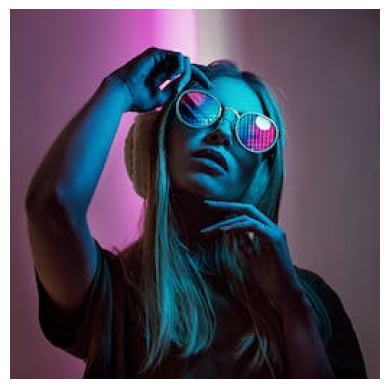

In [7]:
show_image(img)

# We want to be able to calculate Cam with Any Model
Example of VGG and resnet, we may also only want to grab activations after certain layers sunch as Conv2d or AveragePooling
but we will start with the last layer from the network and then the last layer

In [8]:
vgg16 = timm.create_model('vgg16', pretrained=True); vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Hooks

In [9]:
from functools import  partial

In [10]:
def hook_visualisation(hook, mod, inp, out):
    if not hasattr(hook, 'visualisation'): 
        hook.visualisation = []

    hook.visualisation.append(out.detach().cpu())

In [11]:
class Hook:
    def __init__(self, m, func):
        self.hook = m.register_forward_hook(partial(func, self))
    def remove(self):
        self.hook.remove()
    def __del__(self):
        self.remove()

# Create a context Manager

In [12]:
class Hooks(list):
    def __init__(self, model, function):
        super().__init__([Hook(m,function) for i, m in enumerate(model)])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(self, i)
    def remove(self):
        #remove all hooks to remove memory
        for h in self:
            h.remove()

In [13]:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std =torch.tensor([0.229, 0.224, 0.225])

In [14]:
import json
class_idx = json.load(open("/Users/davidgillespie/Downloads/imagenet_class_index.json", 'rb'))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
label2idx = {v:k for k,v in enumerate( idx2label)}

In [15]:
class CAM:
    def __init__(self, model, function, layers = None, transforms = None, layer_type = [nn.Conv2d,nn.ReLU, nn.MaxPool2d, nn.AdaptiveAvgPool2d, nn.SiLU, nn.BatchNorm2d]):
        self.transforms = transforms
        #gonna add all layers that have are either conv2d, Relu etc. 
        #but we are gonna get the one that matches the final weights layer
        #probably better way to do this. 
        self.final_layer = None
        self.model = model
        mods = []
        for m in model.modules():
            # for l in layer_type:
            #     if isinstance(m,l):
            #         mods.append(m)
            #         break
            mods.append(m)
            if isinstance(m, nn.Linear):
                self.final_layer = m
        # print(mods)
        self.hooks = Hooks(mods, function)

    def predict(self, model, img):
        self.model.eval()
        for t in self.transforms: img = t(img)
        output = self.model(img[None,...])
        self.hooks.remove()
        return output

    def display_hook_shapes(self):
        for i,h in enumerate(self.hooks):
            print(h.visualisation[0].squeeze().shape, i)
            
    def cam_vis(self, img, layer=0, hook_layer=0):
        cam_map = self.cam(hook_layer)
        ax = show_image(img)
        ax.imshow(cam_map[layer].detach().numpy(), alpha=0.6, extent=(0,img.shape[2], img.shape[1],0),
              interpolation='bilinear', cmap='magma');
        
        
    def cam(self, hook_layer=0):
        fl_shape = self.final_layer.weight.shape[1]
        act = self.hooks[hook_layer].visualisation[0].squeeze()
        #check if we need to resize
        cam_act = act.clone()
        print(act.shape[0])
        if fl_shape !=act.shape[0]:
            cam_act = torch.zeros((fl_shape, act.shape[1], act.shape[2]))
            cam_act[:act.shape[0]] = act
        #get the grad cam
        cam_map = torch.einsum('bk,kij->bij', a.final_layer.weight, cam_act)
        return cam_map
        
                                  
                

In [16]:
a = CAM(vgg16, hook_visualisation,  transforms=[torchvision.transforms.Normalize(imagenet_mean, imagenet_std)])

In [17]:
output = a.predict(vgg16, img)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [18]:
torch.argmax(output)

tensor(643)

In [19]:
a.display_hook_shapes()

torch.Size([1000]) 0
torch.Size([512, 8, 8]) 1
torch.Size([64, 256, 256]) 2
torch.Size([64, 256, 256]) 3
torch.Size([64, 256, 256]) 4
torch.Size([64, 256, 256]) 5
torch.Size([64, 128, 128]) 6
torch.Size([128, 128, 128]) 7
torch.Size([128, 128, 128]) 8
torch.Size([128, 128, 128]) 9
torch.Size([128, 128, 128]) 10
torch.Size([128, 64, 64]) 11
torch.Size([256, 64, 64]) 12
torch.Size([256, 64, 64]) 13
torch.Size([256, 64, 64]) 14
torch.Size([256, 64, 64]) 15
torch.Size([256, 64, 64]) 16
torch.Size([256, 64, 64]) 17
torch.Size([256, 32, 32]) 18
torch.Size([512, 32, 32]) 19
torch.Size([512, 32, 32]) 20
torch.Size([512, 32, 32]) 21
torch.Size([512, 32, 32]) 22
torch.Size([512, 32, 32]) 23
torch.Size([512, 32, 32]) 24
torch.Size([512, 16, 16]) 25
torch.Size([512, 16, 16]) 26
torch.Size([512, 16, 16]) 27
torch.Size([512, 16, 16]) 28
torch.Size([512, 16, 16]) 29
torch.Size([512, 16, 16]) 30
torch.Size([512, 16, 16]) 31
torch.Size([512, 8, 8]) 32
torch.Size([4096, 2, 2]) 33
torch.Size([4096, 2, 2]

512


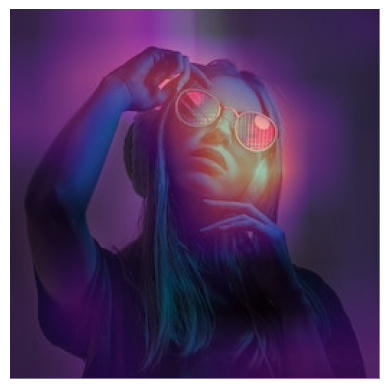

In [20]:
a.cam_vis(img, 643,32)

# Resnet

In [21]:
resnet = timm.create_model('resnet34', pretrained=True)

In [22]:
a = CAM(resnet, hook_visualisation,  transforms=[torchvision.transforms.Normalize(imagenet_mean, imagenet_std)])

In [23]:
output = a.predict(resnet, img)

In [24]:
a.display_hook_shapes()

torch.Size([1000]) 0
torch.Size([64, 128, 128]) 1
torch.Size([64, 128, 128]) 2
torch.Size([64, 128, 128]) 3
torch.Size([64, 64, 64]) 4
torch.Size([64, 64, 64]) 5
torch.Size([64, 64, 64]) 6
torch.Size([64, 64, 64]) 7
torch.Size([64, 64, 64]) 8
torch.Size([64, 64, 64]) 9
torch.Size([64, 64, 64]) 10
torch.Size([64, 64, 64]) 11
torch.Size([64, 64, 64]) 12
torch.Size([64, 64, 64]) 13
torch.Size([64, 64, 64]) 14
torch.Size([64, 64, 64]) 15
torch.Size([64, 64, 64]) 16
torch.Size([64, 64, 64]) 17
torch.Size([64, 64, 64]) 18
torch.Size([64, 64, 64]) 19
torch.Size([64, 64, 64]) 20
torch.Size([64, 64, 64]) 21
torch.Size([64, 64, 64]) 22
torch.Size([64, 64, 64]) 23
torch.Size([64, 64, 64]) 24
torch.Size([64, 64, 64]) 25
torch.Size([64, 64, 64]) 26
torch.Size([64, 64, 64]) 27
torch.Size([64, 64, 64]) 28
torch.Size([64, 64, 64]) 29
torch.Size([64, 64, 64]) 30
torch.Size([64, 64, 64]) 31
torch.Size([64, 64, 64]) 32
torch.Size([128, 32, 32]) 33
torch.Size([128, 32, 32]) 34
torch.Size([128, 32, 32]) 35

512


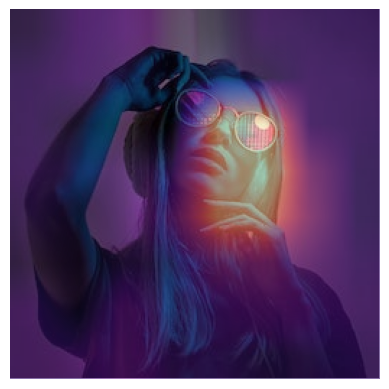

In [25]:
a.cam_vis(img, 643, 160)

In [27]:
## Lets try Convnext

In [32]:
print(timm.list_models('*next*'))

['bat_resnext26ts', 'coatnext_nano_rw_224', 'convnext_atto', 'convnext_atto_ols', 'convnext_base', 'convnext_femto', 'convnext_femto_ols', 'convnext_large', 'convnext_large_mlp', 'convnext_nano', 'convnext_nano_ols', 'convnext_pico', 'convnext_pico_ols', 'convnext_small', 'convnext_tiny', 'convnext_tiny_hnf', 'convnext_xlarge', 'convnext_xxlarge', 'convnextv2_atto', 'convnextv2_base', 'convnextv2_femto', 'convnextv2_huge', 'convnextv2_large', 'convnextv2_nano', 'convnextv2_pico', 'convnextv2_small', 'convnextv2_tiny', 'cspresnext50', 'dla60_res2next', 'eca_botnext26ts_256', 'eca_halonext26ts', 'eca_resnext26ts', 'ecaresnext26t_32x4d', 'ecaresnext50t_32x4d', 'edgenext_base', 'edgenext_small', 'edgenext_small_rw', 'edgenext_x_small', 'edgenext_xx_small', 'gcresnext26ts', 'gcresnext50ts', 'inception_next_base', 'inception_next_small', 'inception_next_tiny', 'legacy_seresnext26_32x4d', 'legacy_seresnext50_32x4d', 'legacy_seresnext101_32x4d', 'res2next50', 'resnext26ts', 'resnext50_32x4d', 

In [33]:
convnext = timm.create_model('convnext_base', pretrained=True)

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

In [34]:
convnext

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [35]:
a = CAM(convnext, hook_visualisation,  transforms=[torchvision.transforms.Normalize(imagenet_mean, imagenet_std)])

In [36]:
output = a.predict(convnext, img)

In [37]:
torch.argmax(output)

tensor(837)

In [38]:
a.display_hook_shapes()

torch.Size([1000]) 0
torch.Size([128, 64, 64]) 1
torch.Size([128, 64, 64]) 2
torch.Size([128, 64, 64]) 3
torch.Size([1024, 8, 8]) 4
torch.Size([128, 64, 64]) 5
torch.Size([128, 64, 64]) 6
torch.Size([128, 64, 64]) 7
torch.Size([128, 64, 64]) 8
torch.Size([128, 64, 64]) 9
torch.Size([64, 64, 128]) 10
torch.Size([64, 64, 128]) 11
torch.Size([64, 64, 512]) 12
torch.Size([64, 64, 512]) 13
torch.Size([64, 64, 512]) 14
torch.Size([64, 64, 512]) 15
torch.Size([64, 64, 128]) 16
torch.Size([64, 64, 128]) 17
torch.Size([128, 64, 64]) 18
torch.Size([128, 64, 64]) 19
torch.Size([128, 64, 64]) 20
torch.Size([128, 64, 64]) 21
torch.Size([64, 64, 128]) 22
torch.Size([64, 64, 128]) 23
torch.Size([64, 64, 512]) 24
torch.Size([64, 64, 512]) 25
torch.Size([64, 64, 512]) 26
torch.Size([64, 64, 512]) 27
torch.Size([64, 64, 128]) 28
torch.Size([64, 64, 128]) 29
torch.Size([128, 64, 64]) 30
torch.Size([128, 64, 64]) 31
torch.Size([128, 64, 64]) 32
torch.Size([128, 64, 64]) 33
torch.Size([64, 64, 128]) 34
tor

1024


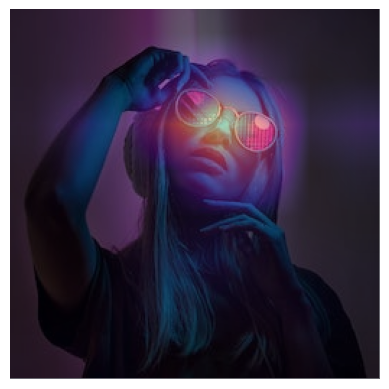

In [39]:
a.cam_vis(img, 837, 455) 

In [40]:
idx2label[837]

'sunglasses'